# Instalaçao do dataset / bibliotecas 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install imageio==2.23.0
!pip install pillow==10.0.0
!pip install SimpleITK


In [85]:
import numpy as np
import SimpleITK as sitk
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import os
import seaborn as sn
import PIL

In [86]:
data_dir = '/kaggle/input/luna16/subset0/subset0'

# Processamento / segmentaçao de imagens

In [87]:
def read_mhd_raw(mhd_path):
    # Read the .mhd file
    mhd_image = sitk.ReadImage(mhd_path)

    # Get metadata
    dimensions = mhd_image.GetSize()      # This returns a tuple of image dimensions (e.g., (512, 512, 100))
    data_type = mhd_image.GetPixelID()
    spacing = mhd_image.GetSpacing()

    # Map SimpleITK pixel type to NumPy data type
    pixel_type_mapping = {
        sitk.sitkInt16: np.int16,
        sitk.sitkUInt16: np.uint16,
        sitk.sitkInt32: np.int32,
        sitk.sitkUInt32: np.uint32,
        sitk.sitkFloat32: np.float32,
        sitk.sitkFloat64: np.float64,
        # Add other mappings as needed
    }

    numpy_data_type = pixel_type_mapping.get(data_type)

    if numpy_data_type is None:
        raise ValueError(f"Unsupported SimpleITK pixel type: {data_type}")

    # Read the .raw file as a NumPy array
    raw_path = mhd_path.replace('.mhd', '.raw')
    with open(raw_path, 'rb') as f:
        raw_data = np.fromfile(f, dtype=numpy_data_type)  # Use the mapped data type

    # Reshape the NumPy array to the correct image dimensions
    image_array = raw_data.reshape(dimensions[::-1])  # Reverse dimensions for SimpleITK

    # Create a SimpleITK Image
    image = sitk.GetImageFromArray(image_array)
    image.SetSpacing(spacing)

    return image

## 3D --> 2D

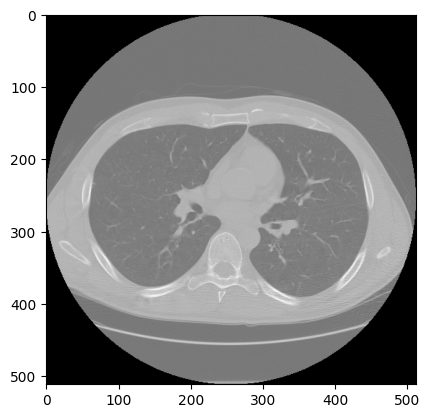

In [88]:
#Teste
im_teste = '/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd'
image = read_mhd_raw(im_teste)

image_array = sitk.GetArrayFromImage(image)

slice_index = image_array.shape[0] // 2  # Seleciona a fatia do meio
plt.imshow(image_array[slice_index, :, :], cmap='gray')
plt.show()


A imagem em si é 3d, mas podemos fatiar e obter seçoes 2d 
image_array[eixo] // num

In [102]:
def data_generator(df, batch_size=32):
    """
    Gera batches de dados para treinamento.

    Args:
        df: DataFrame combinado com informações sobre as imagens e rótulos.
        batch_size: Tamanho do batch.

    Yields:
        Tupla contendo um batch de imagens e um batch de rótulos.
    """
    num_samples = len(df)
    while True:
        # Embaralha o DataFrame a cada época
        df = df.sample(frac=1).reset_index(drop=True)
        for offset in range(0, num_samples, batch_size):
            batch_df = df[offset:offset + batch_size]
            images = []
            labels = []
            for index, row in batch_df.iterrows():
                seriesuid = row['seriesuid']
                mhd_path = os.path.join(data_dir, f"{seriesuid}.mhd")
                try:
                    image = read_mhd_raw(mhd_path)
                    image_array = sitk.GetArrayFromImage(image)

                    images.append(image_array)
                    labels.append(row['class'])

                except Exception as e:
                    print(f"Erro ao ler {mhd_path}: {e}")
                    continue  # Pula para o próximo arquivo se houver um erro

            # Converte as listas de imagens e rótulos para arrays NumPy
            images = np.array(images)
            labels = np.array(labels)

            yield images, labels

In [ ]:
import cv2

In [ ]:
!pip install ultralytics

In [ ]:
!pip install --upgrade pillow

In [111]:
# =================================================================
# 1. Configurações Iniciais
# =================================================================
DATA_DIR = '/kaggle/input/luna16/subset0/subset0'
ANNOTATIONS_PATH = '/kaggle/input/luna16/annotations.csv'
CANDIDATES_PATH = '/kaggle/input/luna16/candidates.csv'
OUTPUT_DIR = '/kaggle/working/yolo_dataset'
YAML_PATH = os.path.join(OUTPUT_DIR, 'lung_nodules.yaml')

# =================================================================
# 2. Funções Auxiliares
# =================================================================
def filter_subset(data_dir, combined_df):
    """Filtra o DataFrame para incluir apenas séries presentes no diretório"""
    try:
        mhd_files = [f for f in os.listdir(data_dir) if f.endswith('.mhd')]
        seriesuids = [os.path.splitext(f)[0] for f in mhd_files]
        
        if not seriesuids:
            raise ValueError("Nenhuma série encontrada no diretório")
            
        filtered_df = combined_df[combined_df['seriesuid'].isin(seriesuids)].copy()
        print(f"Séries carregadas: {len(seriesuids)}")
        print(f"Registros após filtro: {len(filtered_df)}")
        return filtered_df
        
    except Exception as e:
        print(f"Erro na filtragem: {str(e)}")
        return pd.DataFrame()

def get_pixel_spacing(mhd_path):
    """Obtém o espaçamento de pixel do arquivo .mhd"""
    image = sitk.ReadImage(mhd_path)
    return image.GetSpacing()[0]


# Modificar a função apply_ct_window
def apply_ct_window(image, window_center=-600, window_width=1500):
    window_min = window_center - window_width//2
    window_max = window_center + window_width//2
    windowed = np.clip(image, window_min, window_max)
    return cv2.normalize(windowed, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# =================================================================
# 3. Processamento dos Dados
# =================================================================
# Carregar e combinar datasets
annotations = pd.read_csv(ANNOTATIONS_PATH)
candidates = pd.read_csv(CANDIDATES_PATH)

# Mesclar dados
combined_df = pd.merge(
    annotations,
    candidates,
    on=['seriesuid', 'coordX', 'coordY', 'coordZ'],
    how='outer',
    indicator=True
)

combined_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,seriesuid,coordX,coordY,coordZ,diameter_mm,class,_merge
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-138.050000,-150.520000,-335.810000,NaN,0.0,right_only
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-136.650000,-147.020000,-351.270000,NaN,0.0,right_only
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-133.850000,-179.250000,-326.670000,NaN,0.0,right_only
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-133.228273,-131.379818,-340.126364,NaN,0.0,right_only
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-131.040000,-154.020000,-317.540000,NaN,0.0,right_only


In [112]:
# Tratar valores ausentes
combined_df['diameter_mm'] = combined_df['diameter_mm'].fillna(-1)
filtered_df = filter_subset(DATA_DIR, combined_df)
filtered_df = filtered_df[filtered_df['diameter_mm'] > 0].copy()

if filtered_df.empty:
    raise ValueError("Nenhum dado válido após filtragem")

Séries carregadas: 89
Registros após filtro: 57050


In [106]:
# =================================================================
# 4. Preparação do Dataset YOLO
# =================================================================
# Criar estrutura de diretórios
os.makedirs(os.path.join(OUTPUT_DIR, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'labels/train'), exist_ok=True)

# Processar cada série
for idx, row in filtered_df.iterrows():
    try:
        seriesuid = row['seriesuid']
        mhd_path = os.path.join(DATA_DIR, f"{seriesuid}.mhd")
        
        # Processar imagem
        image = sitk.ReadImage(mhd_path)
        image_array = sitk.GetArrayFromImage(image)[0]
        processed = apply_ct_window(image_array)
        
        # Obter metadados
        pixel_spacing = get_pixel_spacing(mhd_path)
        img_h, img_w = processed.shape
        
        # Converter coordenadas
        x_center = row['coordX'] / img_w
        y_center = row['coordY'] / img_h
        diameter_px = row['diameter_mm'] / pixel_spacing
        width = diameter_px / img_w
        height = diameter_px / img_h
        
        # Salvar imagem
        cv2.imwrite(f"{OUTPUT_DIR}/images/train/{seriesuid}.png", processed)
        
        # Salvar anotação
        with open(f"{OUTPUT_DIR}/labels/train/{seriesuid}.txt", 'w') as f:
            f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
            
    except Exception as e:
        print(f"Erro em {seriesuid}: {str(e)}")
        continue

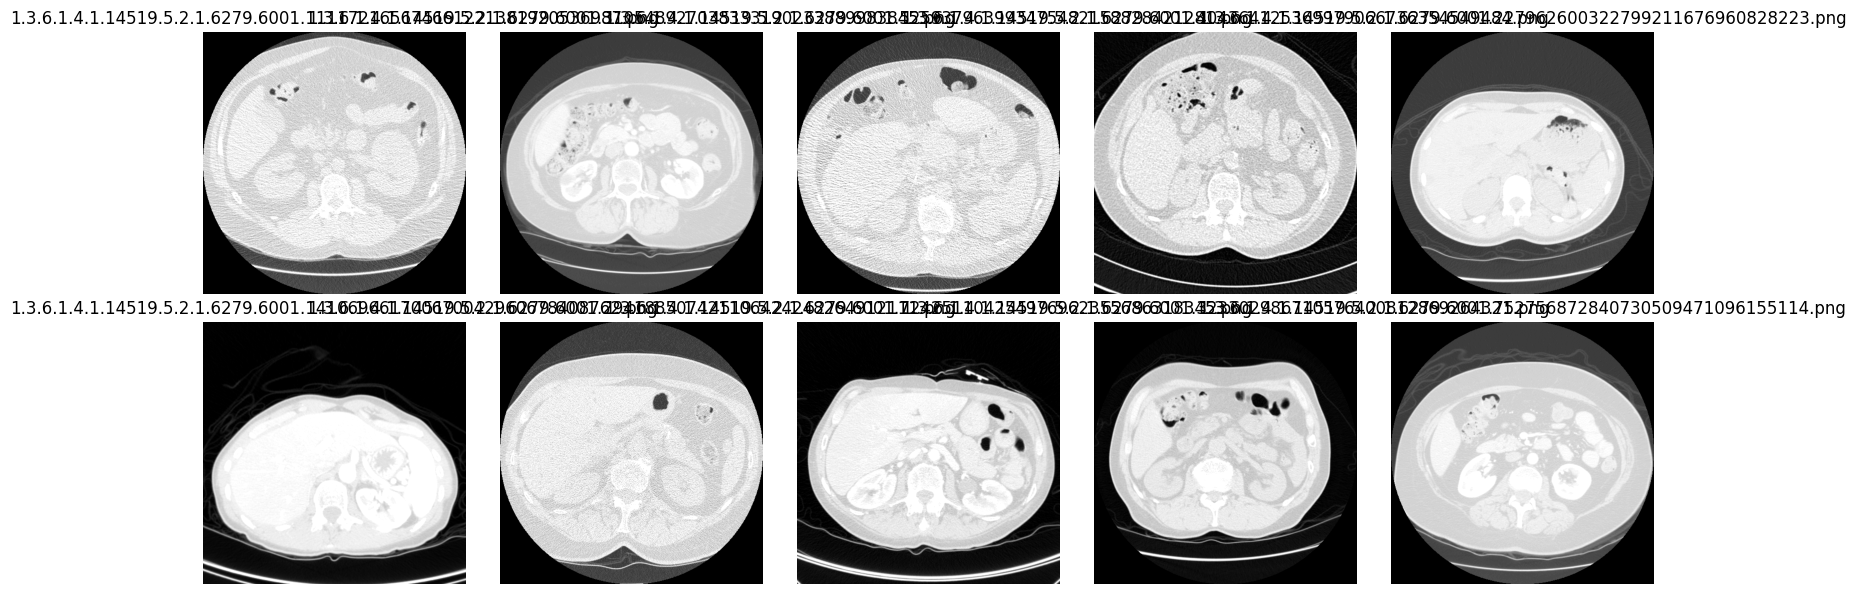

In [113]:
image_dir = os.path.join(OUTPUT_DIR, 'images/train')  

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# Select the first 10 images (or fewer if there are less than 10)
num_images_to_display = min(10, len(image_files))
images_to_display = image_files[:num_images_to_display]

# Create a figure and subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust figsize as needed
axes = axes.ravel()  # Flatten the axes array

# Display each image
for i, image_file in enumerate(images_to_display):
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    axes[i].imshow(image, cmap='gray')  
    axes[i].set_title(image_file)  
    axes[i].axis('off')  

plt.tight_layout()
plt.show()